In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm

In [4]:
train_data_path = join('C:\\DB\\kaggle_data', 'train.csv')
test_data_path = join('C:\\DB\\kaggle_data', 'test.csv')

In [5]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [6]:
print("train.csv. Shape: ",train.shape)
print("test.csv. Shape: ",test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


<AxesSubplot:>

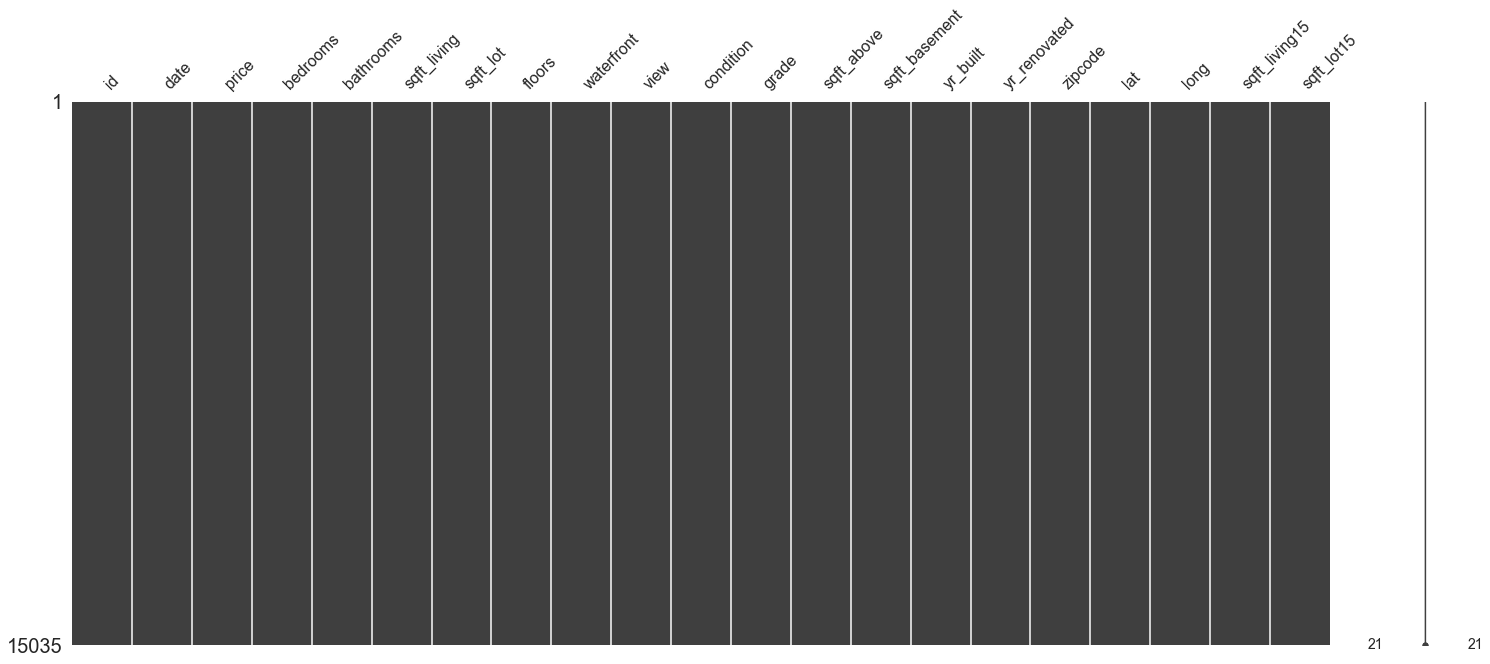

In [24]:
msno.matrix(train)

In [25]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

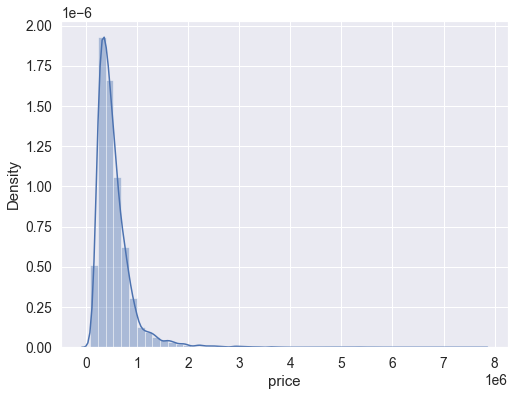

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

In [27]:
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


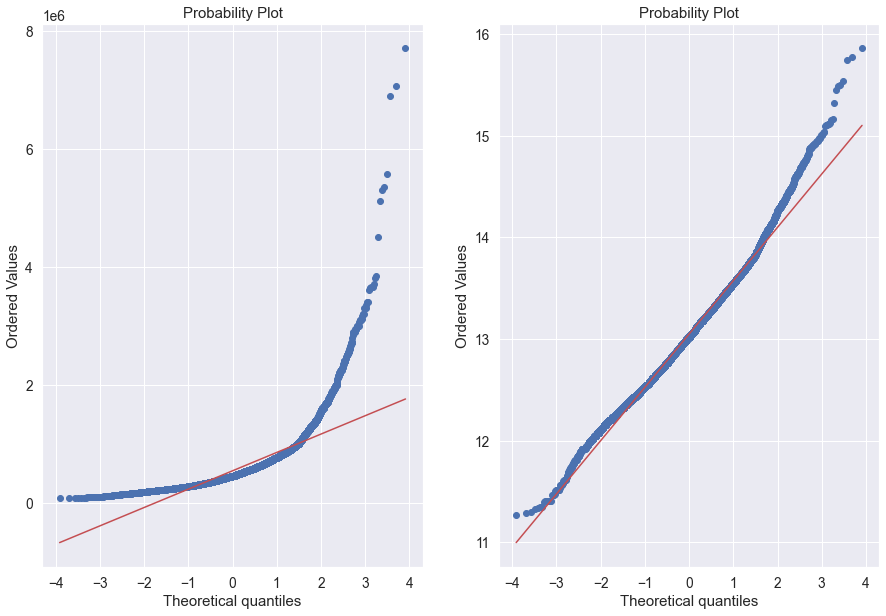

In [28]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['price']), plot=plt)

<AxesSubplot:xlabel='price', ylabel='Density'>

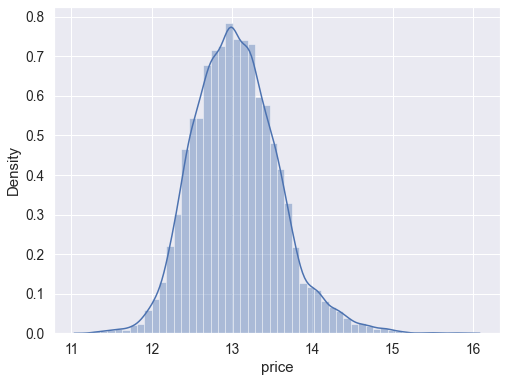

In [29]:
train['price'] = np.log1p(train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

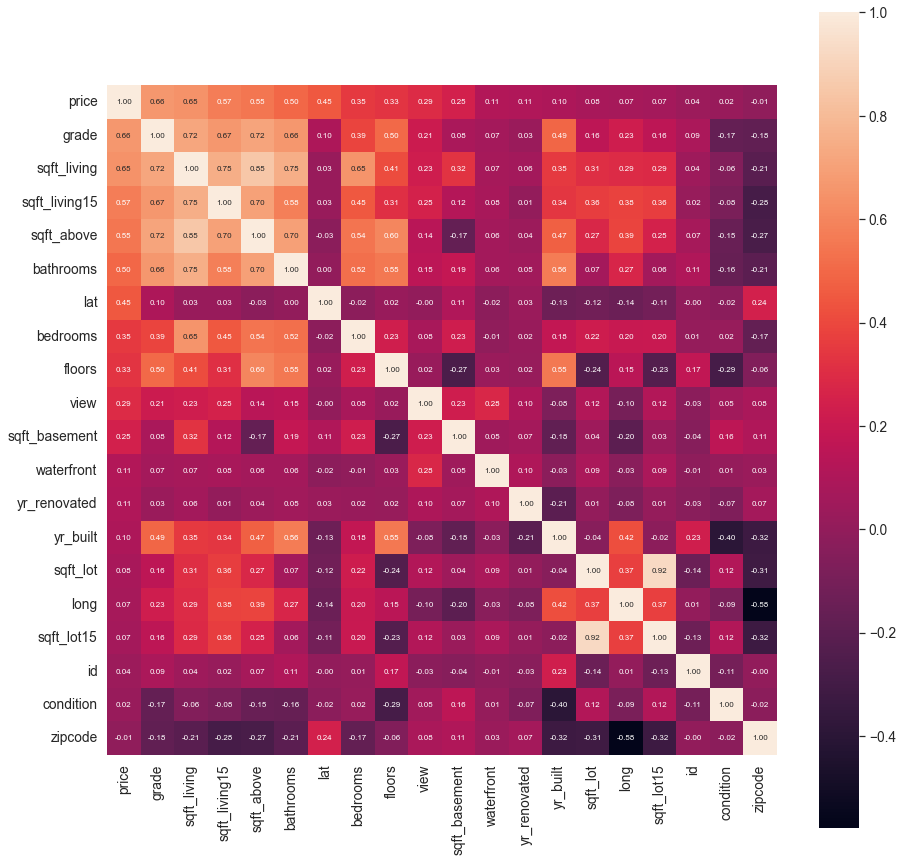

In [30]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 내림차순
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

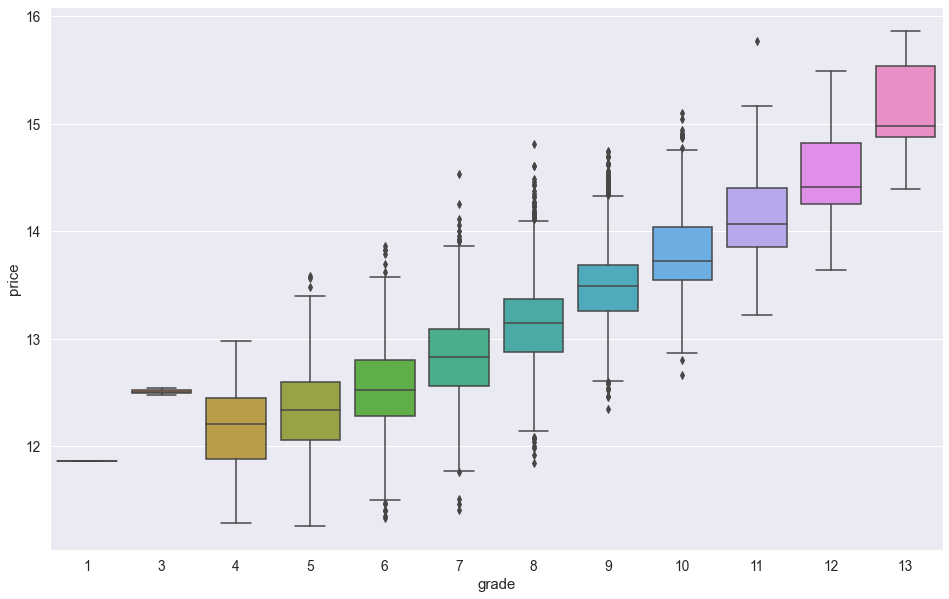

In [31]:
data = pd.concat([train['price'], train['grade']], axis=1)


fig = plt.figure(figsize = (16,10))


fig.add_subplot()
res = sns.boxplot(x='grade', y="price", data=data)

In [32]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [33]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]

In [34]:
train.loc[train['grade'] == 1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13522,13522,20140926T000000,11.863589,0,0.0,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


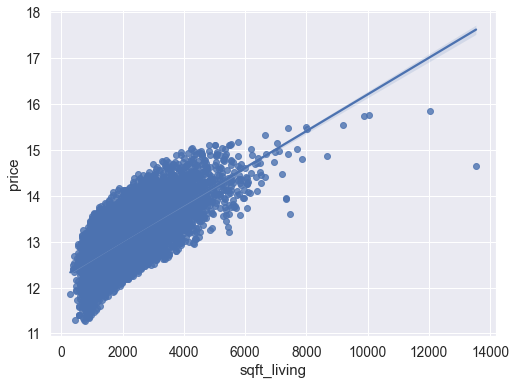

In [35]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [36]:
train.loc[(train['price']>14) & (train['sqft_living'] > 12000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,20141013T000000,15.856731,6,8.0,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [37]:
train = train.loc[train['id']!=8912]

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

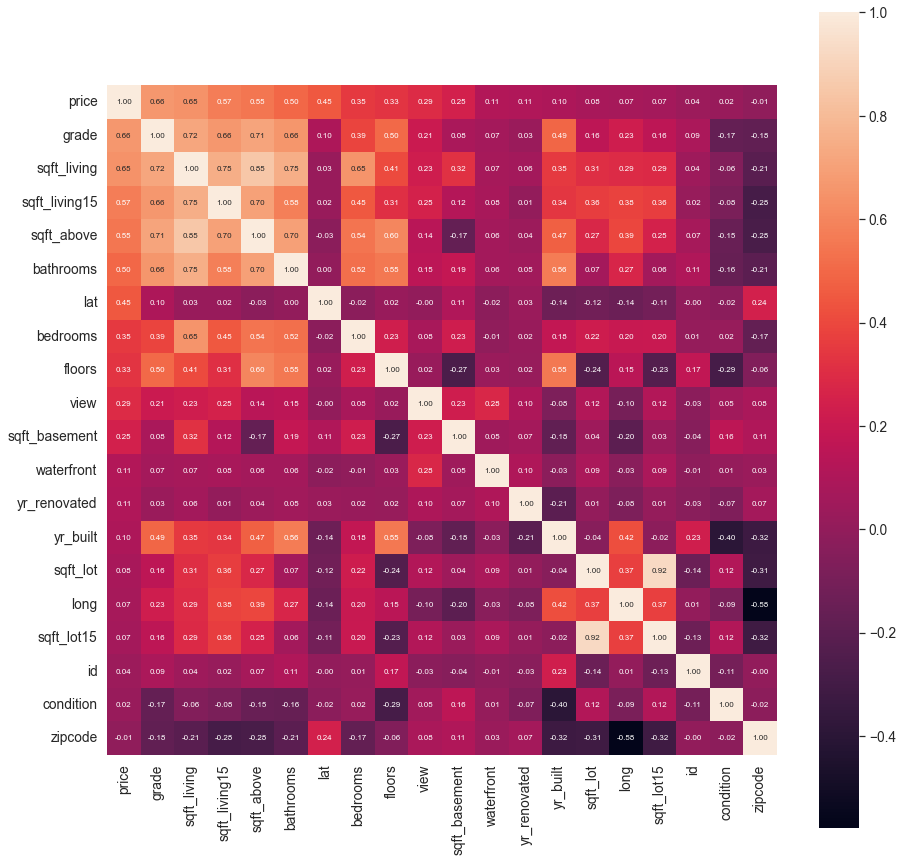

In [38]:
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 내림차순
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [39]:
y = train['price']
del train['price']
del train['condition']
del train['id']
del train['zipcode']
del train['date']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


In [7]:
del test['condition']
del test['id']
del test['zipcode']
del test['date']

print(test.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


In [41]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [42]:
random_state = 2022
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [43]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        df[model_name] = rmse(y_val, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
RandomForestRegressor,138148.213732
GradientBoostingRegressor,138086.315946
XGBRegressor,122308.609526
LGBMRegressor,120611.367980


In [60]:
lgb_params = {
    'boosting_type': ['gbdt', 'rf'],
    'objective':['regression'],
    'num_leave' : [1],
    'learning_rate' : [0.03, 0.1],
    'max_depth' : [6,8],
    'colsample_bytree' : [0.4],
    'subsample' : [0.4],
    'max_bin' : [70,80],
    'gpu_id':[0],         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'metric' : ['rmse'],
    'seed' : [2022]
}


In [110]:
xgb_params = {
    'eta': [0.02],
    'max_depth': [6,8,10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.4, 0.6],
    'objective': ['reg:linear'],    
    'eval_metric': ['rmse'],               
    'seed' : [2022]
}

In [62]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=7, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [63]:
my_GridSearch(lightgbm, train, y, lgb_params, verbose=2, n_jobs=5)

Fitting 7 folds for each of 16 candidates, totalling 112 fits


,boosting_type,colsample_bytree,gpu_id,learning_rate,max_bin,max_depth,metric,num_leave,objective,predictor,seed,subsample,tree_method,score,RMSLE
5,gbdt,0.4,0,0.10,70,8,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.030948,0.175921
7,gbdt,0.4,0,0.10,80,8,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.031085,0.176310
4,gbdt,0.4,0,0.10,70,6,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.031406,0.177217
6,gbdt,0.4,0,0.10,80,6,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.031530,0.177567
1,gbdt,0.4,0,0.03,70,8,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.044396,0.210703
3,gbdt,0.4,0,0.03,80,8,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.044549,0.211067
0,gbdt,0.4,0,0.03,70,6,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.045035,0.212215
2,gbdt,0.4,0,0.03,80,6,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,-0.045083,0.212327
8,rf,0.4,0,0.03,70,6,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,NaN,NaN
9,rf,0.4,0,0.03,70,8,rmse,1,regression,gpu_predictor,2022,0.4,gpu_hist,NaN,NaN


In [111]:
my_GridSearch(xgboost, train, y, xgb_params, verbose=2, n_jobs=5)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[22:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


,colsample_bytree,eta,eval_metric,max_depth,objective,seed,subsample,score,RMSLE
7,0.6,0.02,rmse,6,reg:linear,2022,1.0,-0.030526,0.174717
6,0.6,0.02,rmse,6,reg:linear,2022,0.8,-0.031295,0.176905
9,0.6,0.02,rmse,8,reg:linear,2022,1.0,-0.031558,0.177646
1,0.4,0.02,rmse,6,reg:linear,2022,1.0,-0.031895,0.178591
8,0.6,0.02,rmse,8,reg:linear,2022,0.8,-0.032607,0.180575
0,0.4,0.02,rmse,6,reg:linear,2022,0.8,-0.032638,0.180659
11,0.6,0.02,rmse,10,reg:linear,2022,1.0,-0.033042,0.181776
10,0.6,0.02,rmse,10,reg:linear,2022,0.8,-0.033509,0.183056
3,0.4,0.02,rmse,8,reg:linear,2022,1.0,-0.033574,0.183233
2,0.4,0.02,rmse,8,reg:linear,2022,0.8,-0.034335,0.185297


In [116]:
lgb_model = LGBMRegressor(boosting_type= 'gbdt',
    objective ='regression',
    num_leave = 1,
    learning_rate = 0.10,
    max_depth = 8,
    colsample_bytree = 0.4,
    subsample = 0.4,
    max_bin = 70,
    gpu_id = 0,         
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor',
    refit =True,
    metric = 'rmse',
    seed = 2022)
xgb_model = XGBRegressor(learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    nthread=4,
    scale_pos_weight=1,
    seed= 2022)

In [94]:
X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)

In [124]:
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_val)

lgb_score=np.sqrt(mean_squared_error(y_val,lgb_pred))
print('LGBMoboost 스코어 : {0:.4f}'.format(lgb_score))

[LightGBM] [Warning] Unknown parameter: num_leave
[LightGBM] [Warning] Unknown parameter: refit
[LightGBM] [Warning] Unknown parameter: predictor
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: tree_method
LGBMoboost 스코어 : 0.1760


In [125]:
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)

xgb_score=np.sqrt(mean_squared_error(y_val,xgb_pred))
print('XGBoboost 스코어 : {0:.4f}'.format(xgb_score))

XGBoboost 스코어 : 0.1707


In [126]:
print('LGBMoboost 스코어 : {0:.4f}'.format(lgb_score))
print('XGBoboost 스코어 : {0:.4f}'.format(xgb_score))

LGBMoboost 스코어 : 0.1760
XGBoboost 스코어 : 0.1707


In [127]:
lgb_test = lgb_model.predict(test)
lgb_test = np.expm1(lgb_test)

In [128]:
xgb_test = xgb_model.predict(test)
xgb_test = np.expm1(xgb_test)

In [129]:
preds = 0.4* lgb_test + 0.6*xgb_test

In [131]:
data_dir = 'C:/DB/kaggle_data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = preds
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, 'ensemble_ver6')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

C:/DB/kaggle_data/submission_ensemble_ver6.csv saved!


####회고 2회차  

----  

15만점으로 제출하려니 찝찝하여 2회차를 진행하였다. 이번엔 데이터를 많이 잘라내는 만행을 저지르지 않고  
이상치로 추정되는 값들만 소량 제거 한 데이터를 사용해보았다. 최적의 하이퍼 파라미터를 찾기 위해 GridSearchCV를 진행하고,  
그에 따른 하이퍼 파라미터를 사용하였으나 스코어가 1점대를 넘는 기이한 현상이 발생했다. 많은 고민을 하였지만 이 상황이 해결  
하지 못하였고 몇 몇 우수노드들의 하이퍼 파라미터를 참고하여 간신히 스코어를 0.1XX대로 낮출 수 있었다.  
하이퍼 파라미터는 운이 중요한 것 같다. 그 결과 드디어 11만점대의 점수를 얻을 수 있었다. 끝.  
  
![poster](./Kaggleimage.png)